In [225]:
import os

import numpy as np
import folium
import glob
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import rasterio.plot

In [226]:
year = 2020
path = f"alpha_earth_{year}"

files = glob.glob(path + "/*.npy")
files = sorted(files, key=lambda x: x.split("/")[1][5])
files

['alpha_earth_2020/tile_0_lat37.7749_lon-122.4194.npy',
 'alpha_earth_2020/tile_1_lat40.7128_lon-74.0060.npy',
 'alpha_earth_2020/tile_2_lat34.0522_lon-118.2437.npy',
 'alpha_earth_2020/tile_3_lat47.5049_lon9.7256.npy',
 'alpha_earth_2020/tile_4_lat9.7256_lon47.5049.npy']

In [227]:
embeddings = [np.load(f) for f in files]

# embeddings = embeddings[:3]
# files = files[:3]

In [228]:
[(print(e.shape), print(np.isnan(e).any())) for e in embeddings]

(64, 512, 512)
False
(64, 512, 512)
False
(64, 512, 512)
False
(64, 512, 512)
False
(64, 512, 512)
False


[(None, None), (None, None), (None, None), (None, None), (None, None)]

In [229]:
pca = PCA(n_components=3)

In [230]:
valid = [not bool(np.isnan(e).any()) for e in embeddings]
files = [f for f,v in zip(files, valid) if v]
embeddings = [e for e,v in zip(embeddings, valid) if v]

In [231]:
valid

[True, True, True, True, True]

In [232]:
embeddings_pca = [pca.fit_transform(np.moveaxis(e, 0, -1).reshape(-1, 64)) for e in embeddings]

In [233]:
embeddings_pca = [e.reshape((512, 512, 3)) for e in embeddings_pca]

In [234]:
def visnorm(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

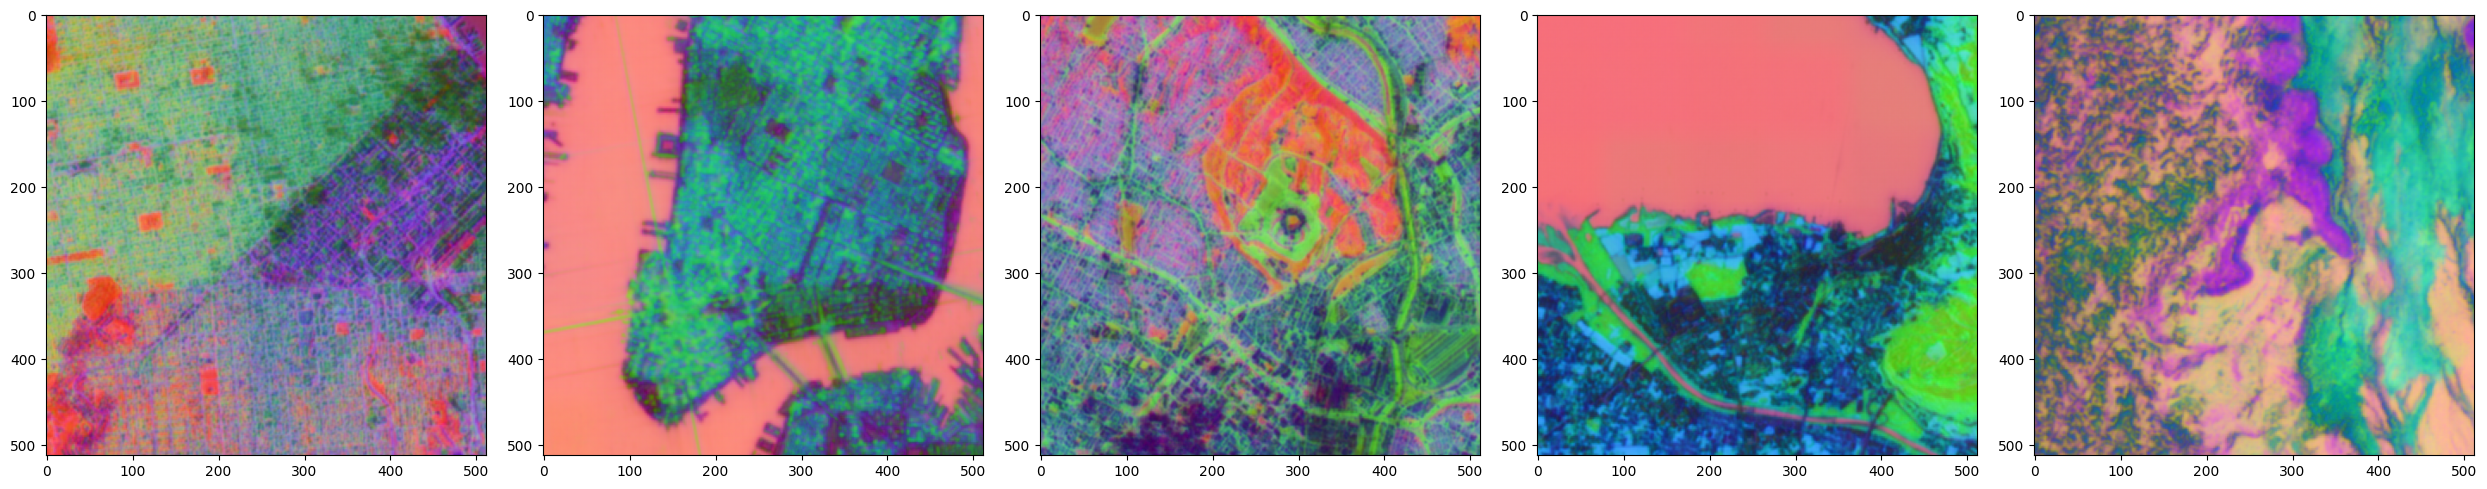

In [235]:
fig, axs = plt.subplots(1, len(files), figsize=(5*len(files), 5))
for idx in range(len(files)):
    axs[idx].imshow(visnorm(embeddings_pca[idx]))

plt.tight_layout()
plt.show()

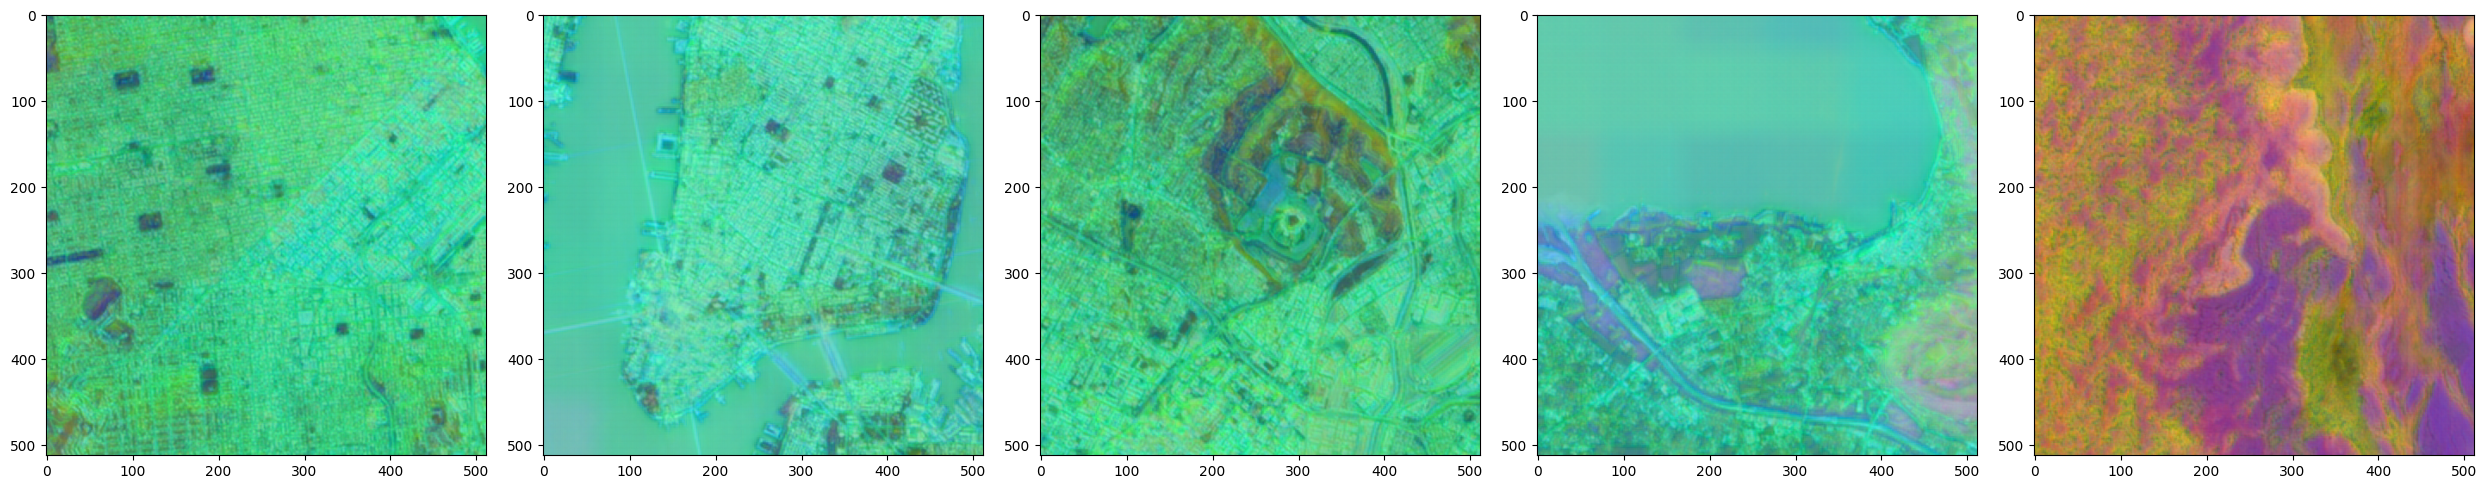

In [236]:
fig, axs = plt.subplots(1, len(files), figsize=(5*len(files), 5))
for idx in range(len(files)):
    axs[idx].imshow(visnorm(rasterio.plot.reshape_as_image(embeddings[idx])[..., [1, 16, 9]]))

plt.tight_layout()
plt.show()

In [237]:
"""
MINIMAL VERSION - Copy this entire cell into Jupyter Notebook

Visualizes Alpha Earth embedding tile extents on an interactive map.
Just set TILE_DIRECTORY and run!
"""

import numpy as np
import folium
from pathlib import Path
import re
from pyproj import Transformer

# ============================================================================
# CONFIGURATION - CHANGE THIS TO YOUR DIRECTORY
# ============================================================================
TILE_DIRECTORY = path # "./alpha_earth_2020"  # <-- Set your directory here
OUTPUT_HTML = "tile_map.html"

# ============================================================================
# CODE (no need to modify below)
# ============================================================================

def extract_latlon(filename):
    """Extract lat/lon from filename like: tile_0_lat37.7749_lon-122.4194.npy"""
    match = re.search(r'lat([-+]?\d+\.?\d*)_lon([-+]?\d+\.?\d*)', filename)
    if match:
        return float(match.group(1)), float(match.group(2))
    raise ValueError(f"Could not parse: {filename}")

def get_corners(lat, lon, size=120, pixel_m=10.0):
    """Get polygon corners for a tile (120x120 pixels @ 10m resolution)"""
    # Determine UTM zone and EPSG
    zone = int((lon + 180) / 6) + 1
    epsg = (32600 if lat >= 0 else 32700) + zone
    
    # Transform to UTM
    to_utm = Transformer.from_crs("EPSG:4326", f"EPSG:{epsg}", always_xy=True)
    x, y = to_utm.transform(lon, lat)
    
    # Calculate corners (half extent in meters)
    half = (size * pixel_m) / 2.0
    corners_utm = [
        (x - half, y + half),  # TL
        (x + half, y + half),  # TR
        (x + half, y - half),  # BR
        (x - half, y - half),  # BL
    ]
    
    # Transform back to lat/lon
    to_latlon = Transformer.from_crs(f"EPSG:{epsg}", "EPSG:4326", always_xy=True)
    return [(to_latlon.transform(x, y)[1], to_latlon.transform(x, y)[0]) 
            for x, y in corners_utm]

# Find all tile files
tiles = list(Path(TILE_DIRECTORY).glob("tile_*.npy"))
print(f"Found {len(tiles)} tiles")

# Extract locations
locations = []
for tile_file in tiles:
    try:
        lat, lon = extract_latlon(tile_file.name)
        locations.append({'lat': lat, 'lon': lon, 'name': tile_file.name})
    except:
        print(f"Skipped: {tile_file.name}")

if not locations:
    raise ValueError(f"No valid tiles found in {TILE_DIRECTORY}")

# Create map
avg_lat = sum(t['lat'] for t in locations) / len(locations)
avg_lon = sum(t['lon'] for t in locations) / len(locations)

m = folium.Map(location=[avg_lat, avg_lon], zoom_start=10)

# Add satellite layer
folium.TileLayer(
    #'Satellite',
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Satellite'
).add_to(m)

# Add tiles
colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'darkgreen', 'darkblue']
for i, loc in enumerate(locations):
    corners = get_corners(loc['lat'], loc['lon'], size=512)
    color = colors[i % len(colors)]
    
    # Polygon
    folium.Polygon(
        locations=corners,
        color=color,
        weight=2,
        fill=True,
        fillColor=color,
        fillOpacity=0.2,
        popup=f"Tile {i}<br>({loc['lat']:.4f}, {loc['lon']:.4f})<br>{loc['name']}",
        tooltip=f"Tile {i}"
    ).add_to(m)
    
    # Center marker
    folium.CircleMarker(
        location=[loc['lat'], loc['lon']],
        radius=3,
        color=color,
        fill=True
    ).add_to(m)

folium.LayerControl().add_to(m)

# Save and display
m.save(OUTPUT_HTML)
print(f"\n✓ Map saved to {OUTPUT_HTML}")
print(f"✓ {len(locations)} tiles visualized")

# Display in notebook
m

Found 5 tiles

✓ Map saved to tile_map.html
✓ 5 tiles visualized


In [201]:
import ee

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()


Enter verification code:  4/1ASc3gC14K8ooVDX3ZmIKJKDGpJp1eD0hhInpS46DYI_fcuRhDv-IpAsjR7U



Successfully saved authorization token.


In [204]:

def get_alpha_earth_file(lat, lon, year):
    """
    Returns the Earth Engine asset ID of the Alpha Earth Embeddings
    image covering the given location and year.
    """

    # Create point geometry
    point = ee.Geometry.Point(lon, lat)

    # Alpha Earth Embeddings collection
    # collection_id = "GOOGLE/Research/AlphaEarth/Embeddings"
    collection_id = 'GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL'

    collection = ee.ImageCollection(collection_id)

    # Filter by year
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    filtered = (
        collection
        .filterDate(start_date, end_date)
        .filterBounds(point)
    )

    # Get first matching image
    image = filtered.first()

    # Fetch image info
    info = image.getInfo()

    if info is None:
        return None

    # Asset ID / file name
    asset_id = info["id"]

    return asset_id

In [209]:
lat = 37.7749     # San Francisco
lon = -122.4194
year = 2021

asset = get_alpha_earth_file(lat, lon, year)

if asset:
    print("Alpha Earth embedding file:")
    print(asset)
else:
    print("No embedding found for this location/year.")

Alpha Earth embedding file:
GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL/xgi48lqsqj8bcovwk


In [238]:
import math

def get_utm_zone(lat, lon):
    zone = int(math.floor((lon + 180) / 6) + 1)
    hemisphere = "N" if lat >= 0 else "S"
    return zone, hemisphere


# Example
lat, lon = 34.0522, -118.2437

zone, hemi = get_utm_zone(lat, lon)

print(f"UTM Zone: {zone}{hemi}")


UTM Zone: 11N


In [ ]:
get_utm_zone_gee(lat, lon)

import ee
import math

ee.Initialize()


def get_utm_zone_gee(lat, lon):
    point = ee.Geometry.Point(lon, lat)

    # Compute zone number
    zone = int(math.floor((lon + 180) / 6) + 1)

    # EPSG codes:
    # Northern: 32601–32660
    # Southern: 32701–32760
    if lat >= 0:
        epsg = 32600 + zone
        hemi = "N"
    else:
        epsg = 32700 + zone
        hemi = "S"

    proj = ee.Projection(f"EPSG:{epsg}")

    # Transform point
    utm_point = point.transform(proj, 1)

    coords = utm_point.coordinates().getInfo()

    return {
        "zone": zone,
        "hemisphere": hemi,
        "epsg": f"EPSG:{epsg}",
        "easting": coords[0],
        "northing": coords[1],
    }



In [243]:
file = "ae_embeddings/air_pollution/2020/0016c627-2fb1-53eb-8ce0-343d89b18ba5.tiff"

with rasterio.open(file) as f:
    data = f.read()
    print(f.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -128.0, 'width': 5, 'height': 5, 'count': 64, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32617"]]'), 'transform': Affine(10.0, 0.0, 557500.0,
       0.0, -10.0, 4776480.0), 'blockxsize': 512, 'blockysize': 128, 'tiled': True, 'interleave': 'pixel'}


In [247]:
data.min(), data.max()

(np.float32(-0.3839139), np.float32(0.27613997))